In [ ]:
%load_ext autoreload
%autoreload 1
%aimport Speech_Data_util
%aimport Signal_processing_utils

In [202]:
import sys
sys.path.insert(0, "/Users/evanpan/Documents/GitHub/EvansToolBox/Utils/")
import numpy as np
from scipy import signal
from scipy import stats, spatial, ndimage
import json
import librosa
import math
import os
import pickle as pkl
from matplotlib import pyplot as plt
from Speech_Data_util import Sentence_word_phone_parser
from Geometry_Util import rotation_angles_frome_positions
from Signal_processing_utils import dx_dt, sparse_key_smoothing, runEuro
from datetime import datetime
import cv2 as cv

# Input Block

In [150]:
input_folder = "/Users/evanpan/Documents/Datasets/Ribhav_processed_dataset/"
input_file = "Madelaine Petsch audition for The Prom"
shot_id = 1
speaker_id = 1

In [223]:

input_file_no_space = "_".join(input_file.split(" "))
shot_file_name = os.path.join(os.path.join(os.path.join(input_folder, "shots"), input_file), "shot_cuts.json")
video_path = os.path.join(*[input_folder, "video", input_file+".mp4"])
audio_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 1))
audio_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.wav".format(shot_id, 2))
script_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 1))
script_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}.txt".format(shot_id, 2))
praatoutput_1_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 1))
praatoutput_2_path = os.path.join(os.path.join(os.path.join(input_folder, "JaliTranscript"), input_file_no_space), "shot_{}_{}_PraatOutput.txt".format(shot_id, 2))
gaze_direction_json_path = os.path.join(*[input_folder, "L2CSNet", input_file+".json"])
head_direction_json_path = os.path.join(*[input_folder, "pose", input_file+".pkl"])
out_path = os.path.join(*["/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points", "video_annotation.json"])


vid = cv.VideoCapture(video_path)
fps = vid.get(cv.CAP_PROP_FPS)
# load the input shots range
shots = json.load(open(shot_file_name))["shots"]
valid_shots = []
t0 = datetime.strptime("00:00:00.0", '%H:%M:%S.%f').timestamp()
for i in range(len(shots)):
    start = datetime.strptime(shots[i][0], '%H:%M:%S.%f').timestamp()
    end = datetime.strptime(shots[i][1], '%H:%M:%S.%f').timestamp()
    if (end-start) >= 5:
        valid_shots.append([start-t0, end-t0])
shot_used_range = valid_shots[shot_id]
range_low = int(np.round(shot_used_range[0] * fps))
range_high = int(np.round(shot_used_range[1] * fps))
ts = np.arange(0, range_high-range_low)/fps+valid_shots[shot_id][0]

# load Head angle data

In [194]:
all_head_data = pkl.load(open(head_direction_json_path, "rb"))
head_angle_data = all_head_data["HEAD"]
head_rotmat_per_frame = head_angle_data["ROTMAT"]
head_euler_per_frame = head_angle_data["EULER"]
head_angle_per_frame = []
neutral_position = np.array([0, 0, 100])
for i in range(0, head_rotmat_per_frame.shape[0]):
    pos = head_rotmat_per_frame[i] @ neutral_position
    head_angle_per_frame.append(rotation_angles_frome_positions(pos[:]))
head_angle_per_frame = np.array(head_angle_per_frame)[range_low:range_high]

# Load gaze_data

In [159]:
f = open(gaze_direction_json_path, "rb")
all_gaze_data = pkl.load(f)
gaze_angle_data = all_gaze_data["RAW_GAZE"]
gaze_angle_per_frame = gaze_angle_data["EULER"][range_low:range_high]
gaze_rotmat_per_frame = gaze_angle_data["ROTMAT"][range_low:range_high]
blinks = all_head_data["BLINKS"][range_low:range_high]


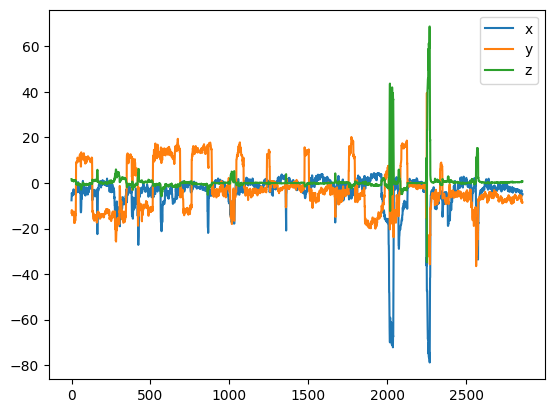

In [160]:
# plotting the raw gaze angle from the rotaiton
name = "xyz"
for i in [0, 1, 2]:
    plt.plot(gaze_angle_per_frame[:, i], label=name[i])
plt.legend()

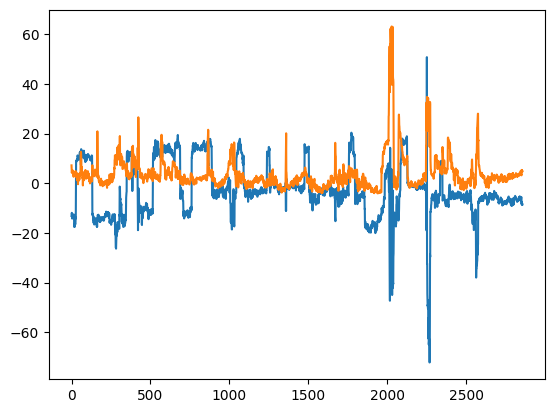

In [201]:
# Scipy does weird things to rotation angles, I will plot the look-at-point instead. 
gaze_vec = np.array([0, 0, 100])
eye_angle_per_frame = []
for i in range(0, gaze_rotmat_per_frame.shape[0]):
    eye_line = gaze_rotmat_per_frame[i] @ gaze_vec
    eye_line = eye_line / eye_line[2] * 100
    eye_angle_per_frame.append(eye_line)
eye_angle_per_frame = np.array(eye_angle_per_frame)
eye_angle_per_frame = rotation_angles_frome_positions(eye_angle_per_frame[:])
filter_eye_angle_per_frame = np.expand_dims(1-blinks, axis=1) * eye_angle_per_frame
name = "xyz"
for i in range(0, 2):
    plt.plot(eye_angle_per_frame[:, i], label=name[i])

In [196]:
def line_search_for_eye_head_ratio(eye, head, window_size = 300):
    # since the eye always move more than the head, we start from a value less than 1.
    multiplicative_factor = []
    window_count = math.ceil(eye.shape[0] / window_size)
    for j in range(0, window_count):
        val = -1
        a_max = 1
        a_min = 0
        if j < window_count - 1:
            for i in range(0, 8):
                mid = (a_max + a_min)/2
                val_left = np.linalg.norm((a_min + mid) / 2 * eye[j*window_size:(j+1)*window_size] - head[j*window_size:(j+1)*window_size])
                val_right = np.linalg.norm((a_max + mid) / 2 * eye[j*window_size:(j+1)*window_size] - head[j*window_size:(j+1)*window_size])
                if val_left < val_right:
                    a_max = mid
                else:
                    a_min = mid
            val = (a_min + a_max) / 2
            for i in range(0, window_size):
                multiplicative_factor.append(val)
        else:
            for i in range(0, 8):
                mid = (a_max + a_min)/2
                val_left = np.linalg.norm((a_min + mid) / 2 * eye[j*window_size:] - head[j*window_size:])
                val_right = np.linalg.norm((a_max + mid) / 2 * eye[j*window_size:] - head[j*window_size:])
                if val_left < val_right:
                    a_max = mid
                else:
                    a_min = mid
            val = (a_min + a_max) / 2
            for i in range(0, head.shape[0] - j*window_size):
                multiplicative_factor.append(val)
    return multiplicative_factor  

### Get the component of head motion that is Irrespective to the gaze direction

In [225]:
gesture_only_head_motion = []
for i in range(0, 2):
    head = head_angle_per_frame[:, i]
    head_smooth = ndimage.gaussian_filter1d(head, sigma=10)
    delta_head = head-head_smooth
    gesture_only_head_motion.append(delta_head)
# export them to a json file so I can see what they look like in maya
out_json = {"ts":ts.tolist(), 
            "no_gaze_head":[ndimage.gaussian_filter1d(gesture_only_head_motion[0], sigma=3).tolist(), 
                            ndimage.gaussian_filter1d(gesture_only_head_motion[1], sigma=3).tolist()],
            "all_head":[ndimage.gaussian_filter1d(head_angle_per_frame[:, 0], sigma=3).tolist(), 
                            ndimage.gaussian_filter1d(head_angle_per_frame[:, 1], sigma=3).tolist()], }

json.dump(out_json, open(out_path, "w"))
out_path

'/Users/evanpan/Documents/GitHub/Gaze_project/data/look_at_points/video_annotation.json'

# Plot gaze heatmap

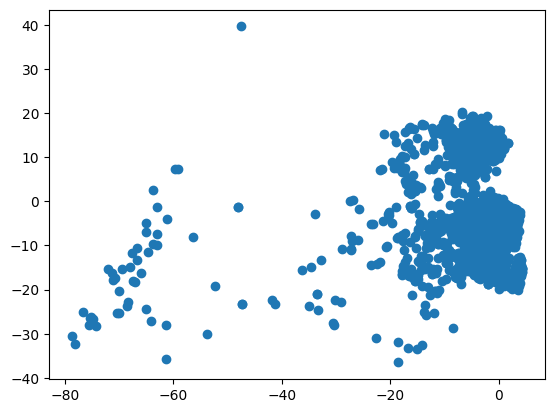

In [200]:
plt.scatter(gaze_angle_per_frame[:, 0], gaze_angle_per_frame[:, 1])